# Getting started

To get started, we need to make sure we have the right packages. The packages for surrogate construction and plotting is `tesuract` and `clif`. `tesuract` can be downloaded using `pip install tesuract` or getting the source from [here](https://github.com/kennychowdhary/tesuract). `clif` is a private repo and you should have got an invitation to be a collaborator. The link is [here](https://github.com/kennychowdhary/clif). We will use `clif` for plotting and some preprocessing transforms, but it is not required. 

These packages, and other will require the following third party libraries:

```
xarray
dask
numpy 
matplotlib
netcdf4
scikit-learn
cartopy (optional)
```

Once you have all those packages installed, we can begin loading and plotting the data. 

## Understanding the data

The data is saved as a netcdf file, which is similar to a pandas style data frame. We will load is as an xarray data set which will allow us to load a whole bunch of meta data along with the numpy arrays. For example, the data sets we will be looking at are latitude-longitude fields. If we were to import the data as a pure numpy array, we would lose the latitude or longitude indices associated with each row and column of the data set. xarray allows us to store that information. It is a mix between pandas and numpy, and it becoming increasingly utilized in the climate world. 

The data sets are broken up by seasons (DJF - December, January, February). So for DJF/ winter, we have two separate `*.nc` files or netcdf files. `lat_lon_10yr_24x48_DJF.nc` contains simulation data from 250 independent runs of E3SM. It contains different climatologies or outputs of the model such as shortwave and longwave cloud forcing, and total precipitation. Let's see how to load this data and what it looks like. 

In [11]:
!conda install cartop

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

^C


In [1]:
import sklearn

In [2]:
import pandas as pd

In [3]:
import numpy as np
import xarray as xr
import dask

In [4]:
cd ../../../src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [19]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})

In [6]:
# The data set contains a list of variables that we can print
list(dataset.variables)

['PRECT',
 'FLNT',
 'FSNT',
 'LWCF',
 'PRECC',
 'PRECL',
 'PSL',
 'RH500',
 'SWCF',
 'T500',
 'TREFHT',
 'U200',
 'U850',
 'Z500',
 'area',
 'climatology_bounds',
 'gw',
 'lat',
 'lat_bnds',
 'lon',
 'lon_bnds',
 'time',
 'x',
 'lhs',
 'lhs_bnds',
 'n']

For our purposes, we will only need a few of these variables. The variables of interest will be 

```
SWCF (shortwave cloud forcing W/m^2)
LWCF (longwave cloud forcing W/m^2)
PRECT (total precipitation m/day)
area (latitude/ longitude area weights of grids, not equally spaced)
lhs (Latin hypercuve sampling tuning parameters/ feature space samples X)
lhs_bnds (bounds on feature space parameters - for re-scaling)
```

Let's extract the SWCF variable and the LHS points 

In [7]:
ls

large_model_plot.png       lat_lon_10yr_24x48_MAM.nc  lat_lon_24x48_MAM_obs.nc
lat_lon_10yr_24x48_DJF.nc  lat_lon_24x48_DJF_obs.nc   lat_lon_24x48_SON_obs.nc
lat_lon_10yr_24x48_JJA.nc  lat_lon_24x48_JJA_obs.nc   trials/


In [8]:
import cartopy

In [9]:
# Extract the training data for SWCF
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

Now that we extracted the training data, let's explore its shape. The first dimension is always the sampling dimension, as standard in ML. Thus, each row of the dataset corresponds to a different sample

In [10]:
X

<xarray.DataArray 'lhs' (n: 250, x: 5)>
dask.array<open_dataset-13561cc2f670246eab0995cceeb57145lhs, shape=(250, 5), dtype=float64, chunksize=(1, 5), chunktype=numpy.ndarray>
Coordinates:
    time     object ...
  * x        (x) object 'ice_sed_ai' 'clubb_c1' ... 'zmconv_tau' 'zmconv_dmpdz'
  * n        (n) int64 1 2 3 4 5 6 7 8 9 ... 242 243 244 245 246 247 248 249 250

$X$ is of size $250 \times 5$ corresponding to $250$ training samples and $5$-dimensional feature space. Each row represents a different set of parameters and the corresponding E3SM model simulation output is given in $Y$. 

In [11]:
Y

<xarray.DataArray 'SWCF' (n: 250, lat: 24, lon: 48)>
dask.array<open_dataset-13561cc2f670246eab0995cceeb57145SWCF, shape=(250, 24, 48), dtype=float32, chunksize=(1, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -84.38 -77.09 -69.76 -62.43 ... 69.76 77.09 84.38
  * lon      (lon) float64 0.0 7.5 15.0 22.5 30.0 ... 330.0 337.5 345.0 352.5
    time     object ...
  * n        (n) int64 1 2 3 4 5 6 7 8 9 ... 242 243 244 245 246 247 248 249 250
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Shortwave cloud forcing
    standard_name:      toa_shortwave_cloud_radiative_effect
    cell_methods:       time: mean within years time: mean over years
    cell_measures:      area: area

$Y$ is of size $250 \times 24 \times 48$, thus each sample of $Y$ is a $24\times48$ *image* or spatially varying latitude-longitude field. As you can see above, $Y$ is a three dimensional tensor (it's actually 4 but we ignore the time), with latitude and longitude coordinates. 

$(X,Y)$ represent input/ output pairs of the E3SM climate model. We will use this data to creat a regression model that maps/ interpolates $X$ to $Y$. We do this so we can calibrate the climate model, i.e., we want to find the optimal input value such that $Y$ matches some observed climate data. That is, 

$$x^* = \arg \min_{x} \|Y_{\mathrm{E^3SM}}(x) - Y_{\mathrm{obs}} \| $$

Since E3SM is too computationally expensive, instead, we solve 

$$x^* = \arg \min_{x} \|Y_{\mathrm{surrogate}}(x) - Y_{\mathrm{obs}} \| $$, 

where we replace the full model with a machine learning surrogate. This optimization can be solved quickly given that the surrogate is differentiable and easy to evaluate. 

This observed data can be loaded from the corresponding netcdf file from the same data directory.   

In [12]:
season

'DJF'

In [13]:
# Load the observation or reference data
#dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_obs

<xarray.DataArray 'SWCF' (lat: 24, lon: 48)>
dask.array<open_dataset-cda1d284d8871d3a0efdc489148f0e60SWCF, shape=(24, 48), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -84.38 -77.09 -69.76 -62.43 ... 69.76 77.09 84.38
  * lon      (lon) float64 0.0 7.5 15.0 22.5 30.0 ... 330.0 337.5 345.0 352.5
    time     datetime64[ns] ...
    plev     float64 ...
Attributes:
    standard_name:  TOA CRE Shortwave Flux
    long_name:      Top of The Atmosphere Cloud Radiative Effects Shortwave F...
    units:          W m-2
    CF_name:        toa_shortwave_cloud_radiative_effect
    comment:        Calculated as all-sky flux minus clear-sky (for total reg...
    valid_min:           -400.000
    valid_max:            100.000
    cell_methods:   time: mean
    cell_measures:  area: area

In [14]:
ls

large_model_plot.png       lat_lon_10yr_24x48_MAM.nc  lat_lon_24x48_MAM_obs.nc
lat_lon_10yr_24x48_DJF.nc  lat_lon_24x48_DJF_obs.nc   lat_lon_24x48_SON_obs.nc
lat_lon_10yr_24x48_JJA.nc  lat_lon_24x48_JJA_obs.nc   trials/


In [15]:
Y_obs

<xarray.DataArray 'SWCF' (lat: 24, lon: 48)>
dask.array<open_dataset-cda1d284d8871d3a0efdc489148f0e60SWCF, shape=(24, 48), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -84.38 -77.09 -69.76 -62.43 ... 69.76 77.09 84.38
  * lon      (lon) float64 0.0 7.5 15.0 22.5 30.0 ... 330.0 337.5 345.0 352.5
    time     datetime64[ns] ...
    plev     float64 ...
Attributes:
    standard_name:  TOA CRE Shortwave Flux
    long_name:      Top of The Atmosphere Cloud Radiative Effects Shortwave F...
    units:          W m-2
    CF_name:        toa_shortwave_cloud_radiative_effect
    comment:        Calculated as all-sky flux minus clear-sky (for total reg...
    valid_min:           -400.000
    valid_max:            100.000
    cell_methods:   time: mean
    cell_measures:  area: area

## Visualizing the data

In order to get a better sense of the data, let us use `clif` to visualize the data. Under neath the hood it uses cartopy so make sure you have installed that package. Once `clif` is installed, we will load the viz module and setup a contour plot. 

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/clif/visualization/contour.py:260: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(self.cplt_, cax=cbax, drawedges=True, alpha=0.5)
/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


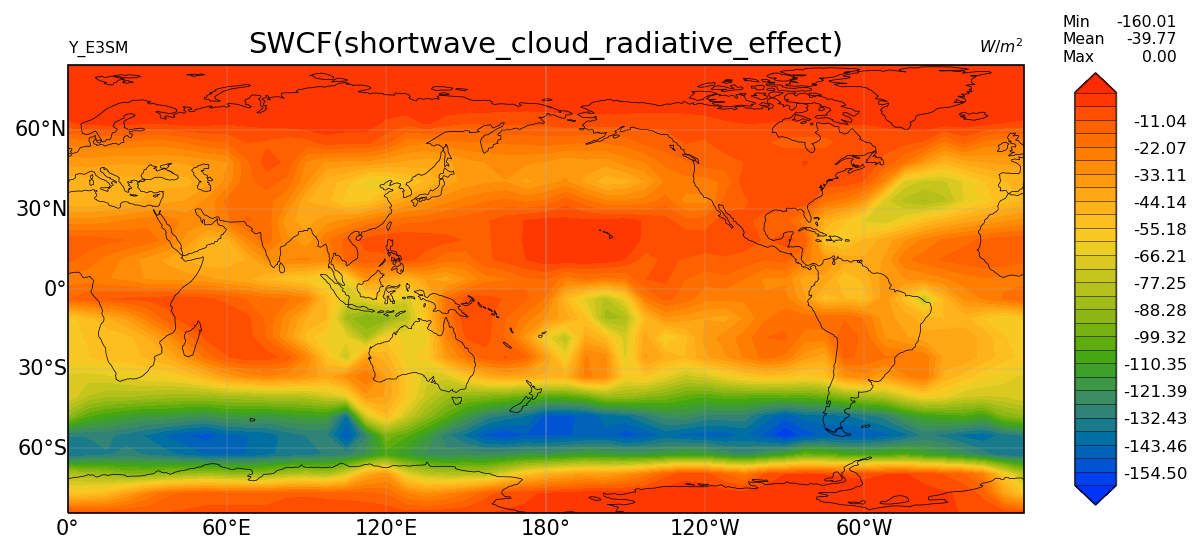

In [16]:
# import the lat lon contour plotting class
import clif
import clif.visualization as cviz

# Now we initialize the contout.plot_lat_lon class with some parameters like the color map and titles
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="SWCF(shortwave_cloud_radiative_effect)",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(Y[0])

SWCF shows how much of the sun's radiation is reflected back into the atmosphere due to the affect of clouds. A larger negative value means that the reflection is greater. So in the winter months, where the souther hemisphere is in summer, the SWCF is larger (in magnitude), as shown in blue. Similarly, we would see the oppositve pattern in the summer months. 

For comparison we can also show the observed SWCF over the past ten years. 

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/clif/visualization/contour.py:260: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(self.cplt_, cax=cbax, drawedges=True, alpha=0.5)


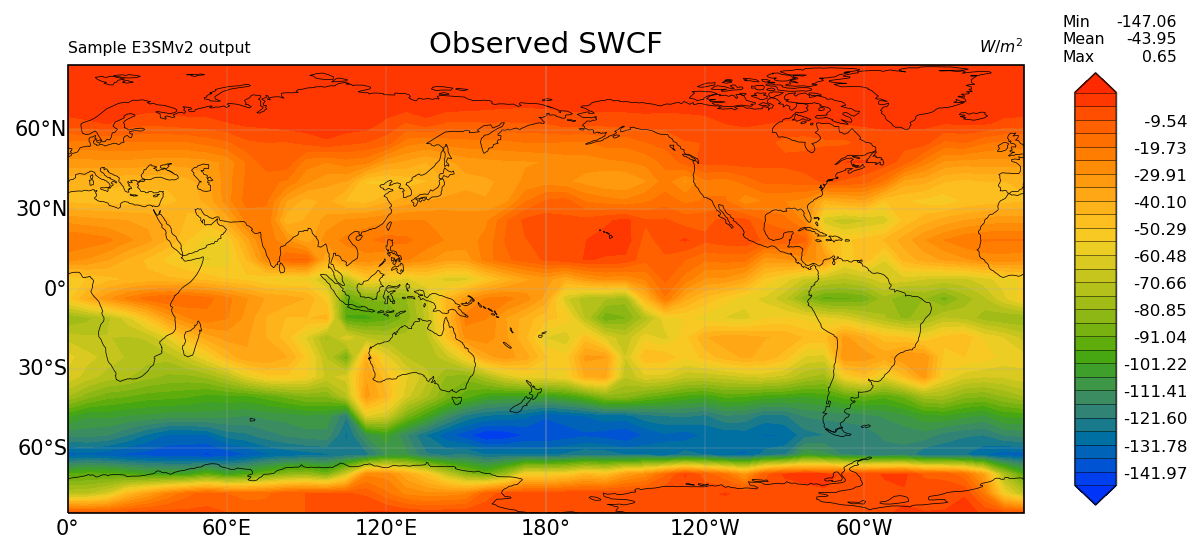

In [17]:
# show observation
# Now we initialize the contout.plot_lat_lon class with some parameters like the color map and titles
obs_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Observed SWCF",
    rhs_title=r"$W/m^2$",
    lhs_title="Sample E3SMv2 output",
)
obs_plot.show(Y_obs)

Finally, we can plot the different between the sample and the observed data. 

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/clif/visualization/contour.py:260: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(self.cplt_, cax=cbax, drawedges=True, alpha=0.5)


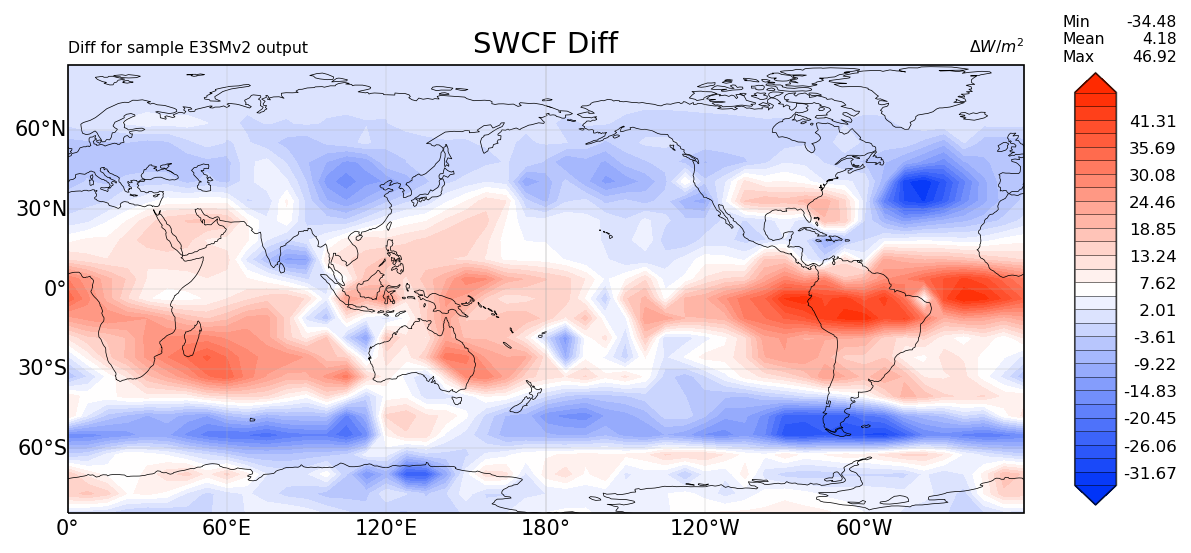

In [18]:
diff_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="SWCF Diff",
    rhs_title=r"$\Delta W/m^2$",
    lhs_title="Diff for sample E3SMv2 output",
)
diff_plot.show(Y[0] - Y_obs)